In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Load your dataset
#df = pd.read_csv("/Users/edilbekabdyrakhmanov/Documents/GitHub/bakeryy/0_DataPreparation/initialdata/merged_data_temperature+holidays+weather_impressions.csv")
df = pd.read_csv("../../0_DataPreparation/initialdata/merged_data_temperature+holidays+weather_impressions.csv")
# Ensure the 'Datum' column is in datetime format
df['Datum'] = pd.to_datetime(df['Datum'])

# If 'Weekday' column does not exist, create it
if 'Weekday' not in df.columns:
    df['Weekday'] = df['Datum'].dt.day_name()

# Define time ranges
train_start = '2013-07-01'
train_end = '2017-07-31'
val_start = '2017-08-01'
val_end = '2018-07-31'
test_start = '2018-08-01'
test_end = '2019-07-30'

# Split data
train_data = df[(df['Datum'] >= train_start) & (df['Datum'] <= train_end)]
validation_data = df[(df['Datum'] >= val_start) & (df['Datum'] <= val_end)]
test_data = df[(df['Datum'] >= test_start) & (df['Datum'] <= test_end)]

# Print shapes
print("Train shape:", train_data.shape)
print("Validation shape:", validation_data.shape)
print("Test shape:", test_data.shape)

def prepare_ols_data(data):
    """
    Prepare data for OLS regression with enhanced features
    """
    data = data.copy()
    data['Datum'] = pd.to_datetime(data['Datum'])

    # Add time-based features
    data['Month'] = data['Datum'].dt.month
    data['Day_of_Year'] = data['Datum'].dt.dayofyear
    data['Week_of_Year'] = data['Datum'].dt.isocalendar().week.astype(int)
    data['Quarter'] = data['Datum'].dt.quarter
    data['Year'] = data['Datum'].dt.year

    # Cyclical encoding
    data['Month_sin'] = np.sin(2 * np.pi * data['Month'] / 12)
    data['Month_cos'] = np.cos(2 * np.pi * data['Month'] / 12)
    data['Day_sin'] = np.sin(2 * np.pi * data['Day_of_Year'] / 365)
    data['Day_cos'] = np.cos(2 * np.pi * data['Day_of_Year'] / 365)
    data['Week_sin'] = np.sin(2 * np.pi * data['Week_of_Year'] / 52)
    data['Week_cos'] = np.cos(2 * np.pi * data['Week_of_Year'] / 52)

    # Fill missing values for key features
    if 'KielerWoche' in data.columns:
        data['KielerWoche'] = data['KielerWoche'].fillna(0)
    if 'Is_Holiday' in data.columns:
        data['Is_Holiday'] = data['Is_Holiday'].fillna(0)
    if 'Temp_Deviation' in data.columns:
        data['Temp_Deviation'] = data['Temp_Deviation'].fillna(data['Temp_Deviation'].median())
    if 'Bewoelkung' in data.columns:
        data['Bewoelkung'] = data['Bewoelkung'].fillna(data['Bewoelkung'].median())
    if 'Weather_Impression' in data.columns:
        data['Weather_Impression'] = data['Weather_Impression'].fillna('Unknown')
    return data

def build_ols_model(train_data, threshold_std=3):
    """
    Build OLS model with enhanced features
    """
    data = prepare_ols_data(train_data)
    Y = data['Umsatz']

    X_components = []

    # 1. Product categories (dummy variables)
    if 'Warengruppe' in data.columns:
        warengruppe_dummies = pd.get_dummies(data['Warengruppe'], prefix='Warengruppe', drop_first=True, dtype=int)
        X_components.append(warengruppe_dummies)
        print(f"Added Warengruppe dummies: {list(warengruppe_dummies.columns)}")

    # 2. Weekday dummies
    if 'Weekday' in data.columns:
        weekday_dummies = pd.get_dummies(data['Weekday'], prefix='Weekday', drop_first=True, dtype=int)
        X_components.append(weekday_dummies)
        print(f"Added Weekday dummies: {list(weekday_dummies.columns)}")

    # 3. Weather impression dummies
    if 'Weather_Impression' in data.columns:
        weather_dummies = pd.get_dummies(data['Weather_Impression'], prefix='Weather', drop_first=True, dtype=int)
        X_components.append(weather_dummies)
        print(f"Added Weather dummies: {list(weather_dummies.columns)}")

    # 4. Continuous weather variables
    continuous_vars = ['Temperatur', 'Windgeschwindigkeit', 'Bewoelkung', 'Temp_Deviation']
    for var in continuous_vars:
        if var in data.columns:
            X_components.append(data[[var]])
            print(f"Added continuous variable: {var}")

    # 5. Binary variables
    binary_vars = ['Is_Holiday', 'KielerWoche']
    for var in binary_vars:
        if var in data.columns:
            X_components.append(data[[var]])
            print(f"Added binary variable: {var}")

    # 6. Time-based features
    time_features = ['Month', 'Quarter', 'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos', 'Week_sin', 'Week_cos']
    for var in time_features:
        if var in data.columns:
            X_components.append(data[[var]])
            print(f"Added time feature: {var}")

    # Combine all components
    X = pd.concat(X_components, axis=1)
    X = sm.add_constant(X)

    print(f"\nFinal feature matrix shape: {X.shape}")
    print(f"Features: {list(X.columns)}")

    # Remove rows with NaN in X or Y
    valid_idx = Y.notna() & X.notna().all(axis=1)
    Y_clean = Y[valid_idx].reset_index(drop=True)
    X_clean = X[valid_idx].reset_index(drop=True)
    
    # 1. Fit initial model
    model_initial = sm.OLS(Y_clean, X_clean).fit()
    predicted_initial = model_initial.predict(X_clean)
    residuals = Y_clean - predicted_initial

    # 2. Bestimme Ausreißer
    threshold = threshold_std * residuals.std()
    mask = residuals.abs() < threshold

    # 3. Entferne Ausreißer
    Y_no_outliers = Y_clean[mask].reset_index(drop=True)
    X_no_outliers = X_clean[mask].reset_index(drop=True)

    # 4. Fit Modell ohne Ausreißer
    model = sm.OLS(Y_no_outliers, X_no_outliers).fit()
    predicted = model.predict(X_no_outliers)
    actual = Y_no_outliers

    print(f"\nData after cleaning:")
    print(f"Observations: {len(Y_clean)}")
    print(f"Features: {X_clean.shape[1]} (including constant)")
    print(model.summary())
    return model, predicted, actual, X_no_outliers, Y_no_outliers

    

Train shape: (7517, 15)
Validation shape: (1839, 15)
Test shape: (351, 15)


In [39]:
# Prepare training data
train_prepared = prepare_ols_data(train_data)

# Build and fit the OLS model
results, predicted, actual, X_clean, Y_clean = build_ols_model(train_prepared)

Added Warengruppe dummies: ['Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Kuchen', 'Warengruppe_Saisonbrot']
Added Weekday dummies: ['Weekday_Monday', 'Weekday_Saturday', 'Weekday_Sunday', 'Weekday_Thursday', 'Weekday_Tuesday', 'Weekday_Wednesday']
Added Weather dummies: ['Weather_good', 'Weather_okay', 'Weather_very bad', 'Weather_very good']
Added continuous variable: Temperatur
Added continuous variable: Windgeschwindigkeit
Added continuous variable: Bewoelkung
Added continuous variable: Temp_Deviation
Added binary variable: Is_Holiday
Added binary variable: KielerWoche
Added time feature: Month
Added time feature: Quarter
Added time feature: Month_sin
Added time feature: Month_cos
Added time feature: Day_sin
Added time feature: Day_cos
Added time feature: Week_sin
Added time feature: Week_cos

Final feature matrix shape: (7517, 30)
Features: ['const', 'Warengruppe_Brötchen', 'Warengruppe_Croissant', 'Warengruppe_Konditorei', 'Warengruppe_Ku

In [40]:
print(predicted.head())
print(actual.head())


0    143.006276
1    420.155654
2    185.639567
3    109.701736
4    298.283961
dtype: float64
0    148.83
1    535.86
2    201.20
3     65.89
4    317.48
Name: Umsatz, dtype: float64


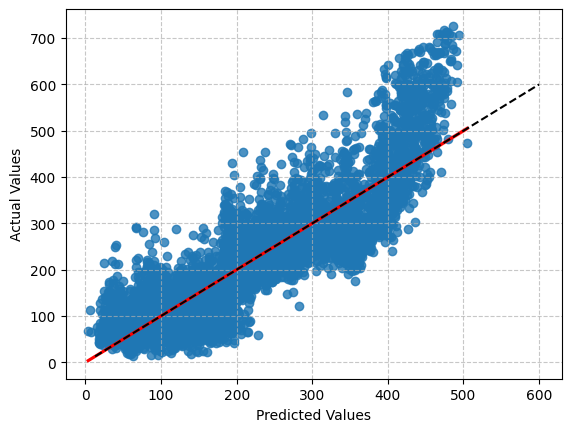

In [41]:
# Plotting the predicted vs actual values
sns.regplot(x=predicted, y=actual, line_kws={"color": "red"})
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.grid(alpha=0.7, linestyle='--')
# adding the perfect y=x line
min = actual.min()
max = 600
plt.plot([min, max], [min, max], color='black', linestyle='--')

In [42]:
# Load test data
test_data = pd.read_csv("../Linear_regression_Lukas/test.csv")
test_data['Datum'] = pd.to_datetime(test_data['Datum'])

# Map numeric 'Warengruppe' codes to product names
warengruppe_mapping = {
    1: 'Brot',
    2: 'Brötchen',
    3: 'Croissant',
    4: 'Konditorei',
    5: 'Kuchen',
    6: 'Saisonbrot'
}
test_data['Warengruppe'] = test_data['Warengruppe'].map(warengruppe_mapping)

# Define holiday dates and create 'Is_Holiday' flag
holidays = pd.to_datetime([
    # 2012–2019 holidays as in training
])
test_data['Is_Holiday'] = test_data['Datum'].isin(holidays).astype(int)

# Add weekday name
test_data['Wochentag'] = test_data['Datum'].dt.day_name()

# Add temperature info from df
test_data = test_data.merge(df[['Datum', 'Temperatur']], on='Datum', how='left')

# find days where temperature is missing
missing_temps = test_data[test_data['Temperatur'].isna()]

# add values for missing temperatures
test_data['Temperatur'].fillna(method='ffill', inplace=True)


/tmp/ipykernel_9146/335102218.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_data['Temperatur'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_9146/335102218.py:32: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_data['Temperatur'].fillna(method='ffill', inplace=True)


In [43]:
# Create dummy variables for test data
X_test = pd.get_dummies(test_data[["Warengruppe", "Is_Holiday", "Wochentag", "Temperatur"]], drop_first=True, dtype=int)
X_test = sm.add_constant(X_test)

# Add missing columns (from training set) to test data, filled with 0
for col in X_clean.columns:
    if col not in X_test.columns:
        X_test[col] = 0

# Reorder columns to match training data
X_test = X_test[X_clean.columns]

# Predict 'Umsatz' using the trained model
preds = results.predict(X_test)

In [46]:
predicted = results.predict(X_clean)
actual = Y_clean
residuals = actual - predicted

comparison_df = pd.DataFrame({
    'Predicted': predicted,
    'Actual': actual,
    'Residuals': residuals
})
print(comparison_df.head())
# print sum of the absolute residuals
print("Sum of absolute residuals:", np.sum(np.abs(residuals)))

    Predicted  Actual   Residuals
0  143.006276  148.83    5.823724
1  420.155654  535.86  115.704346
2  185.639567  201.20   15.560433
3  109.701736   65.89  -43.811736
4  298.283961  317.48   19.196039
Sum of absolute residuals: 346100.6905936977


In [45]:
# Create submission file
submission = pd.DataFrame({
    'id': test_data['id'],
    'Umsatz': preds
})
submission.to_csv("sub4.csv", index=False)